# Python and NumPy Programming Philosophy

If you have experience with other programming languages like C/C++, it my take a while for you to adapt to the Python nd NumPy programming style.The take aways from this tutorial are:
- Python programming style is different than other traditional languages like C/C++. By using built-in commands and functions, you should be able to write clear and concise code. 
- Explicit Python loops are slow. You should avoild explicit Python loops at all costs, and let the compiled NumPy functions do these loops for you.
- For most machine learning applications, using single-precision floating point numbers  is enough and saves you twice the memory.

In [1]:
import numpy as np
import matplotlib.pylab as plt

## Array Initialization

Let's say we want to initialize an one-dimensional array of size  **N** to a constant value **c**. Let's compare the time performance using a traditional programming style like C/C++ and others against the Pythonic way.

In [2]:
N = 100000000
c = 33

In [3]:
%%timeit # built-in magic command https://ipython.readthedocs.io/en/stable/interactive/magics.html

a = np.empty(N)
counter = 0

while counter < N:
    a[counter] = c
    counter+=1

10.8 s ± 327 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit 

a = np.empty(N)
a[:] = c

117 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Counting Positive Values in an Array

Let's count the positive values in an array using an explicit loop and an implicit NumPy loop.

In [12]:
M = 1000000
b = np.random.randn(M) # Random array following normal distribution

In [17]:
%%timeit
nz = 0
for ii in range(b.size):
    if b[ii] > 0:
        nz+=1

289 ms ± 8.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
nz = (b > 0).sum()

1.02 ms ± 9.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Accesing Different Axes of the Array

Now, let's count the number of positive values for each row of a two-dimensional array. 

In [33]:
W = 1000
c = np.random.randn(W,W) # Random array following normal distribution
print(c.shape)

(1000, 1000)


In [36]:
%%timeit
ax = 0 # 0 is the first axis. By convention the first axis are the rows of a 2D array
nz2 = np.empty(c.shape[ax])
counter = 0
# Initialize array to zeros
while counter < W:
    nz2[counter] = 0
    counter+=1

# count positive values
for ii in range(c.shape[0]):
    for jj in range(c.shape[1]):
        if c[ii,jj] > 0:
            nz2[ii]+=1

485 ms ± 9.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
nz2 = (c>0).sum(axis = 1)

1.01 ms ± 6.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Implementing a Function to Compute the Local Binary Pattern

Local Binary Pattern (LBP) is a simple yet very efficient texture feature commonly used in image processing.

<img src="../Figures/lbp.png" width="150" /> 

\begin{align}
LBP(p) = \sum_{i=0}^{7} [f(n_i) > f(p)]2^i$
\end{align}

In [2]:
# First student to propose new implementation that is more efficient and still elegant gets 1 point in the final grade
def local_binary_pattern(img):
    neighbors = [(0,2),(1,2),(2,2),\
                 (2,1), (2,0), (1,0),\
                 (0,0),(0,1)]
    H,W = img.shape
    # np.pad -> can do the padding for you
    aux_img = np.zeros((H+2,W+2))
    aux_img[1:-1,1:-1] = img
    lbp = np.zeros(img.shape, dtype = np.uint8) #uint8
    for i, (x,y) in enumerate(neighbors):
        lbp+= (aux_img[x:H+x,y:W+y] > img)*2**i
    return lbp

float64
(512, 512)


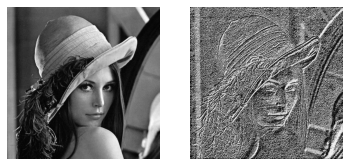

In [5]:
from PIL import Image

img = np.array(Image.open('../Figures/lena.png').convert('L'))
lbp = local_binary_pattern(img)
print(lbp.dtype)
print(img.shape)
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap = "gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(lbp, cmap = "gray")
plt.axis("off")
plt.show()

## Standardizing your data channel-wise

<img src="../Figures/rgb.png" width="400" /> 

Image dimensions: $(H,W,3)$

\begin{align}
f_R = \frac{f_R - mean(f_R)}{std(f_R)}
\end{align}

\begin{align}
f_G = \frac{f_G - mean(f_G)}{std(f_G)}
\end{align}


\begin{align}
f_B = \frac{f_B - mean(f_B)}{std(f_B)}
\end{align}


In [8]:
def standardize_img(f):
    f_new = (f - f.mean(axis = (0,1)))/f.std(axis = (0,1))
    return f_new

In [17]:
img = np.array(Image.open('../Figures/lena.png').convert('RGB'))[:510,:,:]
print(img.shape)
print(img.mean())


print(img.mean(axis = (0),keepdims = True).shape)

img2 = standardize_img(img)

# Before scaling
print(img.mean(axis = (0,1)))
print(img.std(axis = (0,1)))

# After scaling
print(img2.mean(axis = (0,1)))
print(img2.std(axis = (0,1)))

(510, 512, 3)
89.10454197303922
(1, 512, 3)
[89.10454197 89.10454197 89.10454197]
[60.79930718 60.79930718 60.79930718]
[-7.64950297e-15 -7.64950297e-15 -7.64950297e-15]
[1. 1. 1.]


## Floating point precision

In [18]:
print(img2.nbytes)
print(img2.dtype)

6266880
float64


In [19]:
img3 = img2.astype(np.float32)
print(img3.nbytes)
print(img3.dtype)

3133440
float32


## Loading Datasets and Splitting the Data

In [20]:
import tensorflow as tf

# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() # The data comes already split 
                                                                        # in dev and test sets
print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

Development set
Images:  (60000, 28, 28)
Labels shape: (60000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 28, 28)
Labels shape:  (10000,)


In [21]:
# X -> (#samples, H, W) -> (#samples, H,W, #channels)
X_dev2 = X_dev[:,:,:, np.newaxis]
X_dev3 = X_dev[:,:,np.newaxis,: ]
print(X_dev.shape)
print(X_dev2.shape)
print(X_dev3.shape)

(60000, 28, 28)
(60000, 28, 28, 1)
(60000, 28, 1, 28)


In [23]:
H,W,Z = X_dev.shape
print(X_dev4.shape)


(60000, 28, 28, 1)


In [28]:
X_dev = X_dev.astype(np.float32)
X_dev4 = X_dev.reshape(H,W,Z,1)
print(X_dev[0,0,0])
print(X_dev4[0,0,0,0])
X_dev4[0,0,0,0] = -200
print(X_dev[0,0,0])
print(X_dev4[0,0,0,0])

246.0
246.0
-200.0
-200.0


In [26]:
print(X_dev.dtype) # 0 -255

uint8
